Paquetes necesarios

In [3]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



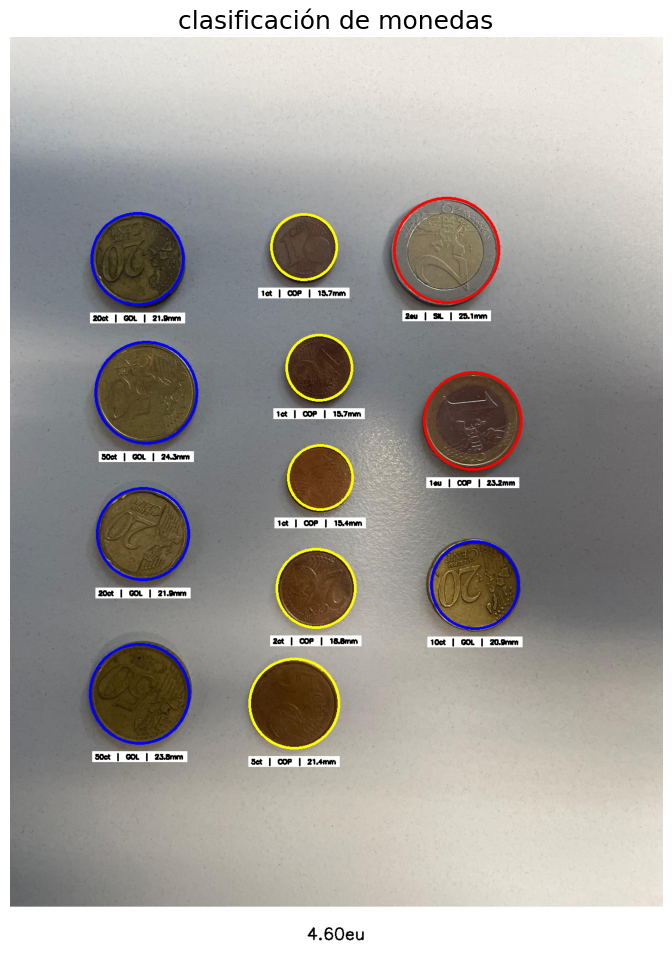

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Definición de los radios conocidos de las monedas en milímetros
COIN_RADII_MM = {
    1: 16.25,
    2: 18.75,
    5: 21.25,
    10: 19.75,
    20: 22.25,
    50: 24.25,
    100: 23.25,
    200: 25.75
}

# Función para seleccionar la moneda de referencia (1 euro) mediante clic del ratón
def select_reference_coin(event, x, y, flags, params):
    global reference_coin
    if event == cv2.EVENT_LBUTTONDOWN and circles is not None:
        for idx, (cx, cy, r) in enumerate(circles[0, :]):
            # Ensure coordinates are within bounds and cast to float to avoid overflow
            cx, cy, x, y = map(float, [cx, cy, x, y])
            if np.hypot(x - cx, y - cy) <= r:
                reference_coin = (cx, cy, r)
                cv2.circle(display_img, (int(cx), int(cy)), int(r), (0, 0, 255), 3)
                cv2.putText(display_img, "1 Euro", (int(cx - 40), int(cy - r - 10)),
                            cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 0, 255), 2)
                cv2.imshow("clica en la moneda de 1€", display_img)
                cv2.waitKey(500)
                cv2.destroyAllWindows()
                return

# Función para analizar el color promedio en HSV
def analyze_coin_color(x, y, patch_size=5):
    height, width = img_hsv.shape[:2]
    half = patch_size // 2
    x1, x2 = max(x - half, 0), min(x + half + 1, width)
    y1, y2 = max(y - half, 0), min(y + half + 1, height)
    
    # Extrae el parche y calcula el promedio en HSV
    patch = img_hsv[y1:y2, x1:x2]
    mean_hsv = np.mean(patch, axis=(0, 1))  # Promedio HSV
    h, s, v = mean_hsv  # OpenCV HSV: H 0-180, S/V 0-255
    
    # Normaliza los valores
    h = h * 2  # a 0-360 grados
    s = s / 255.0
    v = v / 255.0
    
    # Clasificación ajustada basada en rangos HSV investigados
    if s < 0.25:
        return "SILVER"
    elif 0 < h < 70 and s > 0.2 and v > 0.2:
        if h < 35:
            return "COPPER"
        else:
            return "GOLD"
    else:
        return "UNKNOWN"

# 1. Carga y preprocesamiento de la imagen
img = cv2.imread('Monedas 3.jpg')  # Carga la imagen
if img is None:
    raise FileNotFoundError("No se pudo cargar la imagen. Verifica la ruta.")
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # Convierte a espacio de color HSV
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convierte a escala de grises
img_blurred = cv2.medianBlur(img_gray, 5)  # Aplica desenfoque para reducir ruido
display_img = cv2.cvtColor(img_blurred, cv2.COLOR_GRAY2BGR)  # Convierte a BGR para visualización

# 2. Detección de círculos en la imagen usando la transformada de Hough
circles = cv2.HoughCircles(
    img_blurred, cv2.HOUGH_GRADIENT, 1, 100, 
    param1=100, param2=50, minRadius=10, maxRadius=150
)
circles = np.uint16(np.around(circles)) if circles is not None else None
circle_radii = {idx + 1: r for idx, (_, _, r) in enumerate(circles[0, :])} if circles is not None else {}

# 3. Selección interactiva de la moneda de 1 euro
reference_coin = None
cv2.namedWindow("clica en la moneda de 1€", cv2.WINDOW_NORMAL)
cv2.imshow("clica en la moneda de 1€", img)
cv2.setMouseCallback("clica en la moneda de 1€", select_reference_coin)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 4. Clasificación de monedas por tamaño relativo al euro
size_classifications = []
for idx, r in circle_radii.items():
    cx, cy, _ = circles[0, idx - 1]
    radius_mm = r / reference_coin[2] * COIN_RADII_MM[100] if reference_coin else 0
    differences = [(value, abs(radius_mm - r_mm)) for value, r_mm in COIN_RADII_MM.items()]
    differences.sort(key=lambda x: x[1])
    size_classifications.append((idx, [differences[0][0], differences[1][0]]))

# 5. Clasificación por color usando el método HSV
INITIAL_PATCH_SIZE = 5
LARGER_PATCH_SIZE = 10
coin_colors = {}
for idx, (cx, cy, r) in enumerate(circles[0, :], 1):
    cx, cy = int(cx), int(cy)
    points = [
        (cx, cy),  # centro
        (int(cx - 0.9 * r), cy),  # izquierda
        (int(cx + 0.9 * r), cy),  # derecha
        (cx, int(cy - 0.9 * r)),  # arriba
        (cx, int(cy + 0.9 * r))   # abajo
    ]
    
    colors_initial = [analyze_coin_color(px, py, INITIAL_PATCH_SIZE) for px, py in points]
    color_count = Counter(colors_initial)
    
    if "SILVER" in color_count:
        final_color = "SILVER"
    else:
        final_color = color_count.most_common(1)[0][0] if color_count else "UNKNOWN"
    
    if final_color == "UNKNOWN" or len(set(colors_initial)) > 2:
        colors_large = [analyze_coin_color(px, py, LARGER_PATCH_SIZE) for px, py in points]
        color_count = Counter(colors_large)
        if "SILVER" in color_count:
            final_color = "SILVER"
        else:
            final_color = color_count.most_common(1)[0][0] if color_count else "UNKNOWN"

    coin_colors[idx] = final_color

# 6. Combinación de clasificaciones por tamaño y color
COPPER_COINS = [1, 2, 5]
GOLD_COINS = [10, 20, 50]
SILVER_COINS = [100, 200]
final_classifications = []

for idx, candidates in size_classifications:
    color = coin_colors.get(idx, "UNKNOWN")
    color_group = (
        COPPER_COINS if color == "COPPER" else
        GOLD_COINS if color == "GOLD" else
        SILVER_COINS if color == "SILVER" else []
    )
    valid_candidates = [v for v in candidates if v in color_group]
    
    if valid_candidates:
        if len(valid_candidates) == 1:
            final_value = valid_candidates[0]
        else:
            cx, cy, r_px = circles[0, idx - 1]
            radius_mm = r_px / reference_coin[2] * COIN_RADII_MM[100] if reference_coin else 0
            final_value = min(valid_candidates, key=lambda v: abs(COIN_RADII_MM[v] - radius_mm))
    else:
        final_value = candidates[0]
    
    final_classifications.append((idx, final_value, color))

# 7. Cálculo del valor total y conteo de monedas
coin_counts = {value: 0 for value in COIN_RADII_MM}
total_cents = 0
for _, value, _ in final_classifications:
    coin_counts[value] += 1
    total_cents += value

euros, cents = divmod(total_cents, 100)
total_text = f"{euros}.{cents:02d}eu"

# 8. Creación de la imagen final con anotaciones
img_final = img.copy()
for idx, value, color in final_classifications:
    cx, cy, r = circles[0, idx - 1]
    radius_mm = r / reference_coin[2] * COIN_RADII_MM[100] if reference_coin else 0
    label = f"{value//100}eu" if value >= 100 else f"{value}ct"
    text = f"{label}  |  {color[:3]}  |  {radius_mm:.1f}mm"

    if value in [1, 2, 5]:
        border_color = (0, 255, 255)  # Amarillo
    elif value in [10, 20, 50]:
        border_color = (255, 0, 0)    # Azul
    elif value in [100, 200]:
        border_color = (0, 0, 255)    # Rojo

    cv2.circle(img_final, (int(cx), int(cy)), int(r), border_color, 3)

    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = max(0.2, min(0.4, r / 100.0))
    thickness = 1 if r < 50 else 2
    text_size = cv2.getTextSize(text, font, scale, thickness)[0]
    text_x, text_y = int(cx - text_size[0] / 2), int(cy + text_size[1] / 2 + r + 25)

    cv2.rectangle(img_final, (text_x - 5, text_y - text_size[1] - 5),
                  (text_x + text_size[0] + 5, text_y + 5), (255, 255, 255), -1)
    cv2.putText(img_final, text, (text_x, text_y), font, scale, (0, 0, 0), thickness)

# 9. Agrega el valor total centrado en la parte inferior
height, width = img_final.shape[:2]
extra_height = 100
img_with_total = np.zeros((height + extra_height, width, 3), dtype=np.uint8)
img_with_total[:height, :width] = img_final
img_with_total[height:height + extra_height, :width] = 255

font = cv2.FONT_HERSHEY_SIMPLEX
scale = max(0.8, min(1.5, width / 1200.0))
thickness = 2
text_size = cv2.getTextSize(total_text, font, scale, thickness)[0]
text_x = (width - text_size[0]) // 2
text_y = height + 60
cv2.putText(img_with_total, total_text, (text_x, text_y), font, scale, (0, 0, 0), thickness)

# 10. Muestra la imagen final con las clasificaciones y el valor total
plt.figure(figsize=(18, 12))
plt.imshow(cv2.cvtColor(img_with_total, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("clasificación de monedas", fontsize=18)
plt.show()

#Clasificación de microplásticos

El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV sobre una imagen de muestras de microplásticos.

Umbral escogido  197.0


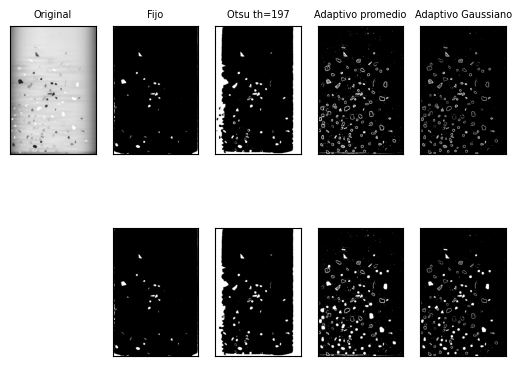

In [28]:
#Carga imagen directamente en grises
imgorig = cv2.imread('MPs_test.jpg', cv2.IMREAD_GRAYSCALE) 

img = cv2.GaussianBlur(imgorig,(5,5),0)

#Umbralizados
ret,imth1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
thotsu,imth2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsu)
imth3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
imth4 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
 
titles = ['Original', 'Fijo','Otsu th='+str(int(thotsu)),
            'Adaptivo promedio', 'Adaptivo Gaussiano']
images = [img, imth1, imth2, 255 - imth3, 255 - imth4]
 
for i in range(5):
    plt.subplot(2,5,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i], fontsize=7)
    plt.xticks([]),plt.yticks([])

    #Obtiene únicamente los contornos externos
    if i>0:
        res,imth = cv2.threshold(images[i],120,255,cv2.THRESH_BINARY)
        contornos, hierarchy= cv2.findContours(imth, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)  
        img_cont = np.zeros(img.shape)
        cv2.drawContours(img_cont, contornos, -1, (255,255,255), -1)  
        plt.subplot(2,5,i+6),plt.imshow(img_cont,'gray')
        plt.xticks([]),plt.yticks([])
plt.show()

Para esta imagen de muestras de microplásticos tenemos una anotación (que puede contener errores) de la tipología de las partículas. Esta será la imagen de test en los experimentos posteriores, no puedes hacer uso de esta imagen para entrenar tu clasificador, solo par evaluarlo

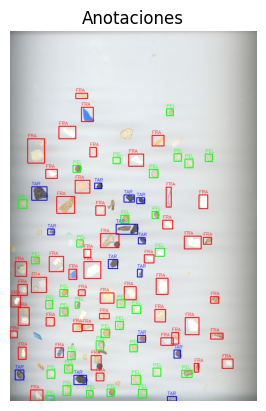

In [11]:
# Imagen y anotaciones
imagen = "MPs_test.jpg"          # Imagen original
csv_file = "MPs_test_bbs.csv"  # CSV con coordenadas y tipología

# Colores de cada clase
colores = {
    "FRA": (0, 0, 255),   # Rojo 
    "PEL": (0, 255, 0),   # Verde
    "TAR": (255, 0, 0)    # Azul
}

# Imagen
img = cv2.imread(imagen)

# Cara csv y dibujar rectángulos
with open(csv_file, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        etiqueta = row["label"]
        x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
        
        # Color según etiqueta
        color = colores.get(etiqueta, (0, 0, 0))  # negro por defecto si no encuentra
        
        # Dibujar rectángulo
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        
        # Etiqueta 
        cv2.putText(img, etiqueta, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Visualiza resultado
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Anotaciones")
plt.axis('off')
plt.show()


##Muestras de entrenamiento

Text(0.5, 1.0, 'Alquitrán')

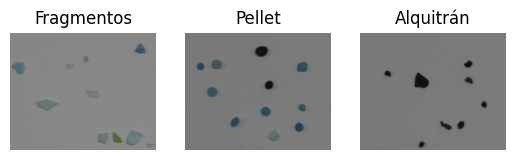

In [12]:
#Cargamos tres subimágenes, por simplicidad, de cada uno de los tres tipos considerados (el alquitrán no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas basadas en características geométricas y/o de apariencia, a partir de las imágenes completas de las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello sobre las anotaciones de la imagen de test *MPs_test.png*. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.

In [13]:

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n = 100  
nclases = 4

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]
print('Anotaciones ' , y)

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]
print('Predicciones ' , y_pred)

print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)

KeyboardInterrupt: 

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.